In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers 
import scipy.stats as stats
import os 
import h5py
import sys
import re
%matplotlib inline 

In [2]:
model_name = "subtract_lepphi_samecenter_Wl_output"

In [3]:
# Throw away lepton mass 
# os.chdir('./../../../../../data/hongtao')
be = h5py.File('./../../../../../data/hongtao/variables_tt_re.h5','r')
bmu = h5py.File('./../../../../../data/hongtao/variables_tt_rmu.h5','r')
be1 = h5py.File('./../../../../../data/hongtao/variables_tt_re2.h5','r')
print(be1.keys())
dataset = be1

<KeysViewHDF5 ['bh_eta', 'bh_m', 'bh_phi', 'bh_pt', 'bl_eta', 'bl_m', 'bl_phi', 'bl_pt', 'j1_DL1r', 'j1_eta', 'j1_isbtag', 'j1_m', 'j1_phi', 'j1_pt', 'j2_DL1r', 'j2_eta', 'j2_isbtag', 'j2_m', 'j2_phi', 'j2_pt', 'j3_DL1r', 'j3_eta', 'j3_isbtag', 'j3_m', 'j3_phi', 'j3_pt', 'j4_DL1r', 'j4_eta', 'j4_isbtag', 'j4_m', 'j4_phi', 'j4_pt', 'j5_DL1r', 'j5_eta', 'j5_isbtag', 'j5_m', 'j5_phi', 'j5_pt', 'j6_DL1r', 'j6_eta', 'j6_isbtag', 'j6_m', 'j6_phi', 'j6_pt', 'j7_DL1r', 'j7_eta', 'j7_isbtag', 'j7_m', 'j7_phi', 'j7_pt', 'j8_DL1r', 'j8_eta', 'j8_isbtag', 'j8_m', 'j8_phi', 'j8_pt', 'lep_eta', 'lep_m', 'lep_phi', 'lep_pt', 'met_met', 'met_phi', 'mttReco', 'mttTrue', 'th_eta', 'th_m', 'th_phi', 'th_pt', 'tl_eta', 'tl_m', 'tl_phi', 'tl_pt', 'true_lep_eta', 'true_lep_m', 'true_lep_phi', 'true_lep_pt', 'wh_eta', 'wh_m', 'wh_phi', 'wh_pt', 'wl_eta', 'wl_m', 'wl_phi', 'wl_pt']>


In [4]:
input_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'j7_pt', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi'] 
output_keys = ['wl_eta', 'wl_phi', 'wl_pt', 'wl_m']
phi_keys = ['j1_phi', 'j2_phi', 'j3_phi','j4_phi','j5_phi','j6_phi', 'lep_phi', 'met_phi', 'th_phi', 'tl_phi', 'wl_phi']
eta_keys = ['j1_eta', 'j2_eta', 'j3_eta', 'j4_eta', 'j5_eta', 'j5_phi', 'j6_eta', 'lep_eta', 'th_eta', 'tl_eta', 'wl_eta']
pt_keys = ['j1_pt', 'j2_pt','j3_pt','j4_pt','j5_pt','j6_pt','lep_pt','th_pt', 'tl_pt', 'wl_pt']
m_keys = ['j1_m','j2_m', 'j3_m', 'j4_m', 'j5_m', 'j6_m', 'wl_m']
DL1r_keys = ['j1_DL1r','j2_DL1r','j3_DL1r','j4_DL1r','j5_DL1r','j6_DL1r']

output_length = len(output_keys)
input_length = len(input_keys)
crop0 =  100000 

In [5]:
# plt.figure(figsize=(8,8*output_length))
# for i in range(0, output_length):
#     plt.subplot(output_length, 1, i+1)
#     plt.hist(dataset.get(output_keys[i]), 20, histtype='step')
#     plt.xlabel(output_keys[i])
#     plt.ylabel('Frequency')

In [6]:
lep_phi = np.array(dataset.get('lep_phi'))[0:crop0]
def phi_transform(arr, max0, mean):
    arr = (arr-mean)
    arr = arr/max0/1.01/2+0.5
    z = stats.norm.ppf(arr)/2.5
    return z 

def invphi_transform(z, max0, mean):
    arr = stats.norm.cdf(2.5*z)
    arr = (arr-0.5)*max0*1.01*2+mean
    return arr 

def jet_existence_dict():
    dic = {}
    for key in phi_keys:
        variable = key.split('_')[0]
        if bool(re.match('^j[0-9]+$', variable)): # If the variable is a jet
            v = np.array(dataset.get(variable + '_pt'))[0:crop0]
            dic[key] = (v>1)*1
        else:
            dic[key] = np.ones(crop0, dtype=int)
    return dic
        
def phi1_transform(arr, max0, mean, exist):
    w = (arr - lep_phi*exist) % (2*np.pi)
    x = w - 2*np.pi*(w>np.pi)
    y = x - (1-exist)*np.pi*1.1
    y = y-mean
    z = y/max0
    return z

def invphi1_transform(z, max0, mean, exist):
    y = z*max0+mean
    x = y+(1-exist)*np.pi*1.1
    w = x + 2*np.pi*(x<0)
    arr = (w + lep_phi*exist) % (2*np.pi)
    arr = arr - 2*np.pi*(arr > np.pi)
    return arr 


def phi2_transform(arr, max0, mean, exist):
    w = (arr - lep_phi*exist) % (2*np.pi)
    # x = w - 2*np.pi*(w>np.pi)
    y = w - (1-exist)*0.2
    z = y/(np.pi)
    return z

def invphi2_transform(z, max0, mean, exist):
    y = z*np.pi
    x = y+(1-exist)*0.2
    # w = x + 2*np.pi*(x<0)
    arr = (x + lep_phi*exist) % (2*np.pi)
    arr = arr - 2*np.pi*(arr > np.pi)
    return arr 


def pt_transform(arr, max0, mean):
    return arr/max0

def invpt_transform(z, max0, mean):
    return z*max0 

def meanmax_transform(arr, max0, mean):
    arr = arr-mean
    z = arr/max0
    return z

def invmeanmax_transform(z, max0, mean):
    return z*max0+mean

def get_maxmean_dict(): 
    to_get = [pt_keys, eta_keys, m_keys, DL1r_keys]
    keys = ['pt', 'eta', 'm','DL1r']
    maxmean= {} 
    
    for i in range(4):
        dset = to_get[i]
        for x in dset:
            arr = []
            arr.append(np.array(dataset.get(x))[0:crop0])
        arr = np.stack(arr,axis=1)
        maxmean[keys[i]] = (np.max(np.abs(arr)), np.mean(arr))
    
    maxmean['phi'] = (np.pi, 0)
    maxmean['met'] = (np.max(np.abs(dataset.get('met_met'))), np.mean(dataset.get('met_met')))
    return maxmean 
    
def scale_arrays(keys, maxmean_dict):
    exist_dict = jet_existence_dict()
    lep_phi = np.array(dataset.get('lep_phi'))[0:crop0]
    
    arrays = []
    for key in keys:
        var = np.array(dataset.get(key))[0:crop0]
        if key in phi_keys:
            max0, mean = maxmean_dict['phi']
            exist = exist_dict[key]
            if False:
                z = phi1_transform(var, max0, mean, exist) 
            else:
                z = phi1_transform(var, max0, mean, exist)
        elif key in pt_keys:
            max0, mean = maxmean_dict['pt']
            z = pt_transform(var, max0, mean)
        elif key in m_keys:
            max0, mean = maxmean_dict['m']
            z = pt_transform(var, max0, mean)
        else:
            max0, mean = maxmean_dict[key.split('_')[1]]
            z = meanmax_transform(var, max0, mean)
        arrays.append(z)
    arrays = np.stack(arrays, axis=1)
    return arrays

def invscale_arrays(keys, arrays, maxmean_dict):
    exist_dict = jet_existence_dict()

    total = []
    for i in range(arrays.shape[1]):
        z=arrays[:,i]
        full_key = keys[i]
        key = keys[i].split('_')[1]
        if key == 'pt':
            max0, mean = maxmean_dict[key]
            total.append(invpt_transform(z, max0, mean))
        elif key=='phi':
            max0, mean = maxmean_dict[key]
            exist = exist_dict[full_key]
            if False:
                total.append(invphi1_transform(z, max0, mean, exist))
            else:
                total.append(invphi1_transform(z, max0, mean, exist))
        elif key=='m':
            max0, mean = maxmean_dict[key]
            total.append(invpt_transform(z, max0, mean))
        else:
            max0, mean = maxmean_dict[key]
            total.append(invmeanmax_transform(z, max0, mean))
            
    return np.stack(total,axis=1) 

In [7]:
# Convert into numpy arrays and mean normalize

maxmean = get_maxmean_dict()
total_input = scale_arrays(input_keys, maxmean)

total_output = scale_arrays(output_keys, maxmean)
out_scaled = invscale_arrays(output_keys, total_output, maxmean)

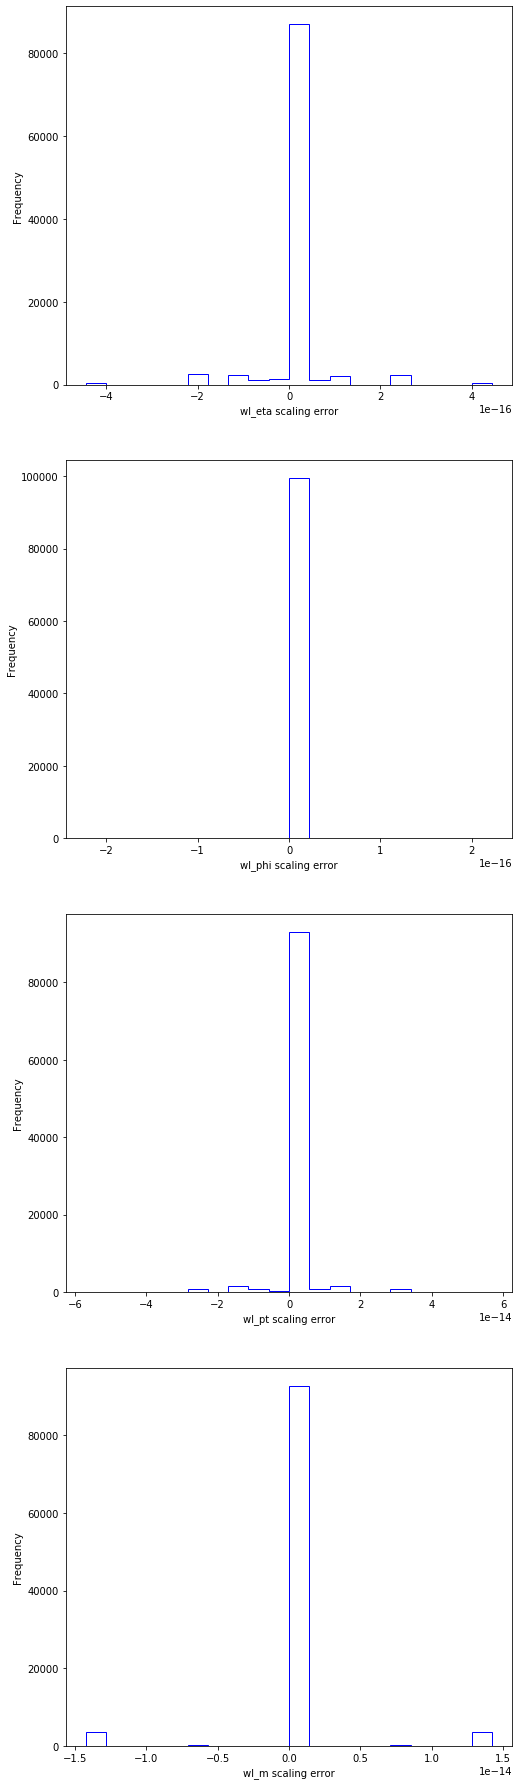

In [8]:
# Test inverse scaling

plt.figure(figsize=(8,8*output_length))
for i in range(len(output_keys)):
    plt.subplot(output_length, 1, i+1)
    plt.hist(dataset.get(output_keys[i])[0:crop0] - out_scaled[:, i], 20, histtype='step', color='b')
    plt.xlabel(output_keys[i] + " scaling error")
    plt.ylabel('Frequency')

In [9]:
# Create input and test array
split = int(np.floor(0.8*crop0)) # 80/20 split 
shuffle = False

if shuffle:
    rng_state = np.random.get_state()
    np.random.shuffle(total_input)
    np.random.set_state(rng_state)
    np.random.shuffle(total_output)

train_input, test_input = total_input[0:split, :], total_input[split:,:]
train_output, test_output = total_output[0:split,:], total_output[split:,:]

In [10]:
print(train_input.shape, train_output.shape)
print(test_input.shape, test_output.shape)

(80000, 36) (80000, 4)
(20000, 36) (20000, 4)


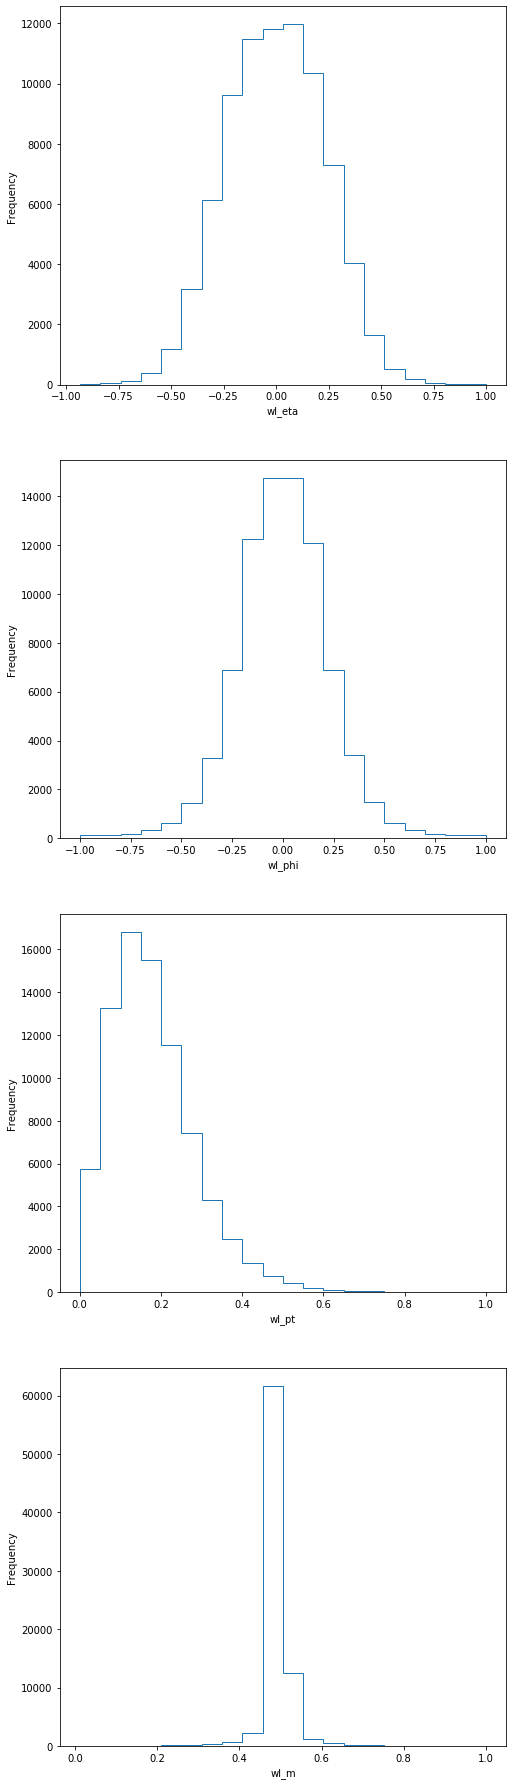

In [11]:
# Histograms of output variables 
show = True

if show:
    plt.figure(figsize=(8,8*output_length))
    for i in range(0, output_length):
        plt.subplot(output_length, 1, i+1)
        plt.hist(train_output[:,i], 20, histtype='step')
        plt.xlabel(output_keys[i])
        plt.ylabel('Frequency')

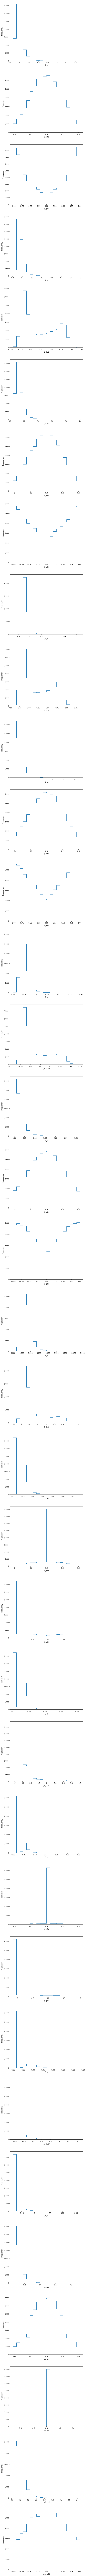

In [12]:
# Histograms of input variables 
show = True

if show:
    plt.figure(figsize=(8,8*input_length))
    for i in range(0, input_length):
        plt.subplot(input_length, 1, i+1)
        plt.hist(train_input[:,i], 20, histtype='step')
        plt.xlabel(input_keys[i])
        plt.ylabel('Frequency')

 

In [13]:
# Build model

# optimizer = keras.optimizers.RMSprop(learning_rate = 1e-5)
optimizer = keras.optimizers.Adam(learning_rate=1e-6)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


def build_model():
    model = keras.Sequential([
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0001),
                     input_shape=[len(input_keys)]),
        layers.Dense(256,  activation='relu'),
        layers.Dense(256,  activation='relu'),
        layers.Dense(256,  activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(len(output_keys),  activation='linear')
    ])
    
    model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    return model 

# def build_model():
#     model = keras.Sequential([
#         layers.Dense(6, activation='linear', 
#                      input_shape=[len(input_keys)])])
    
#     model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    
#     return model 
    

In [14]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               18944     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               1

In [15]:
# Fit model

Epochs= 2048

history = model.fit(train_input, train_output, verbose=1, epochs=Epochs, 
                   validation_split=0.2, shuffle=False, callbacks=[callback],
                   batch_size=512)


Epoch 1/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0951 - mse: 0.0884 - val_loss: 0.0923 - val_mse: 0.0856
Epoch 2/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0905 - mse: 0.0838 - val_loss: 0.0875 - val_mse: 0.0808
Epoch 3/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0854 - mse: 0.0788 - val_loss: 0.0821 - val_mse: 0.0755
Epoch 4/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0799 - mse: 0.0732 - val_loss: 0.0764 - val_mse: 0.0697
Epoch 5/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0739 - mse: 0.0673 - val_loss: 0.0703 - val_mse: 0.0637
Epoch 6/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0678 - mse: 0.0612 - val_loss: 0.0642 - val_mse: 0.0575
Epoch 7/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0617 - mse: 0.0551 - val_loss: 0.0582 - val_mse: 0.0516
Epoch 8/2048
125/125 [==============================] - 1s 5ms

125/125 [==============================] - 1s 5ms/step - loss: 0.0204 - mse: 0.0143 - val_loss: 0.0204 - val_mse: 0.0142
Epoch 62/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0203 - mse: 0.0142 - val_loss: 0.0203 - val_mse: 0.0141
Epoch 63/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0202 - mse: 0.0141 - val_loss: 0.0201 - val_mse: 0.0140
Epoch 64/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0201 - mse: 0.0140 - val_loss: 0.0200 - val_mse: 0.0139
Epoch 65/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0200 - mse: 0.0139 - val_loss: 0.0199 - val_mse: 0.0138
Epoch 66/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0199 - mse: 0.0138 - val_loss: 0.0199 - val_mse: 0.0138
Epoch 67/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0198 - mse: 0.0137 - val_loss: 0.0198 - val_mse: 0.0137
Epoch 68/2048
125/125 [==============================] - 1s 5ms/step 

125/125 [==============================] - 1s 5ms/step - loss: 0.0176 - mse: 0.0120 - val_loss: 0.0176 - val_mse: 0.0121
Epoch 122/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0176 - mse: 0.0120 - val_loss: 0.0176 - val_mse: 0.0121
Epoch 123/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0176 - mse: 0.0120 - val_loss: 0.0176 - val_mse: 0.0120
Epoch 124/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0175 - mse: 0.0120 - val_loss: 0.0176 - val_mse: 0.0120
Epoch 125/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0175 - mse: 0.0120 - val_loss: 0.0175 - val_mse: 0.0120
Epoch 126/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0175 - mse: 0.0120 - val_loss: 0.0175 - val_mse: 0.0120
Epoch 127/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0175 - mse: 0.0119 - val_loss: 0.0175 - val_mse: 0.0120
Epoch 128/2048
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0164 - mse: 0.0114 - val_loss: 0.0165 - val_mse: 0.0114
Epoch 182/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0164 - mse: 0.0113 - val_loss: 0.0164 - val_mse: 0.0114
Epoch 183/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0164 - mse: 0.0113 - val_loss: 0.0164 - val_mse: 0.0114
Epoch 184/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0163 - mse: 0.0113 - val_loss: 0.0164 - val_mse: 0.0114
Epoch 185/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0163 - mse: 0.0113 - val_loss: 0.0164 - val_mse: 0.0114
Epoch 186/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0163 - mse: 0.0113 - val_loss: 0.0164 - val_mse: 0.0114
Epoch 187/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0163 - mse: 0.0113 - val_loss: 0.0164 - val_mse: 0.0114
Epoch 188/2048
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0155 - mse: 0.0109 - val_loss: 0.0156 - val_mse: 0.0111
Epoch 242/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0155 - mse: 0.0109 - val_loss: 0.0156 - val_mse: 0.0110
Epoch 243/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0155 - mse: 0.0109 - val_loss: 0.0156 - val_mse: 0.0110
Epoch 244/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0155 - mse: 0.0109 - val_loss: 0.0156 - val_mse: 0.0110
Epoch 245/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0155 - mse: 0.0109 - val_loss: 0.0156 - val_mse: 0.0110
Epoch 246/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0155 - mse: 0.0109 - val_loss: 0.0156 - val_mse: 0.0110
Epoch 247/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0154 - mse: 0.0109 - val_loss: 0.0155 - val_mse: 0.0110
Epoch 248/2048
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0148 - mse: 0.0106 - val_loss: 0.0149 - val_mse: 0.0108
Epoch 302/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0148 - mse: 0.0106 - val_loss: 0.0149 - val_mse: 0.0108
Epoch 303/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0148 - mse: 0.0106 - val_loss: 0.0149 - val_mse: 0.0108
Epoch 304/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0148 - mse: 0.0106 - val_loss: 0.0149 - val_mse: 0.0108
Epoch 305/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0148 - mse: 0.0106 - val_loss: 0.0149 - val_mse: 0.0108
Epoch 306/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0147 - mse: 0.0106 - val_loss: 0.0149 - val_mse: 0.0108
Epoch 307/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0147 - mse: 0.0106 - val_loss: 0.0149 - val_mse: 0.0108
Epoch 308/2048
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0141 - mse: 0.0103 - val_loss: 0.0143 - val_mse: 0.0105
Epoch 362/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0141 - mse: 0.0103 - val_loss: 0.0143 - val_mse: 0.0105
Epoch 363/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0141 - mse: 0.0103 - val_loss: 0.0143 - val_mse: 0.0105
Epoch 364/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0141 - mse: 0.0103 - val_loss: 0.0143 - val_mse: 0.0105
Epoch 365/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0141 - mse: 0.0103 - val_loss: 0.0143 - val_mse: 0.0105
Epoch 366/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0141 - mse: 0.0103 - val_loss: 0.0143 - val_mse: 0.0105
Epoch 367/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0141 - mse: 0.0103 - val_loss: 0.0143 - val_mse: 0.0105
Epoch 368/2048
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0135 - mse: 0.0100 - val_loss: 0.0138 - val_mse: 0.0102
Epoch 422/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0135 - mse: 0.0100 - val_loss: 0.0138 - val_mse: 0.0102
Epoch 423/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0135 - mse: 0.0100 - val_loss: 0.0138 - val_mse: 0.0102
Epoch 424/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0135 - mse: 0.0099 - val_loss: 0.0138 - val_mse: 0.0102
Epoch 425/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0135 - mse: 0.0099 - val_loss: 0.0138 - val_mse: 0.0102
Epoch 426/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0135 - mse: 0.0099 - val_loss: 0.0137 - val_mse: 0.0102
Epoch 427/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0135 - mse: 0.0099 - val_loss: 0.0137 - val_mse: 0.0102
Epoch 428/2048
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0130 - mse: 0.0096 - val_loss: 0.0133 - val_mse: 0.0100
Epoch 482/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0130 - mse: 0.0096 - val_loss: 0.0133 - val_mse: 0.0100
Epoch 483/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0130 - mse: 0.0096 - val_loss: 0.0133 - val_mse: 0.0100
Epoch 484/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0129 - mse: 0.0096 - val_loss: 0.0133 - val_mse: 0.0100
Epoch 485/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0129 - mse: 0.0096 - val_loss: 0.0133 - val_mse: 0.0099
Epoch 486/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0129 - mse: 0.0096 - val_loss: 0.0133 - val_mse: 0.0099
Epoch 487/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0129 - mse: 0.0096 - val_loss: 0.0133 - val_mse: 0.0099
Epoch 488/2048
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0125 - mse: 0.0094 - val_loss: 0.0129 - val_mse: 0.0098
Epoch 542/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0125 - mse: 0.0094 - val_loss: 0.0129 - val_mse: 0.0098
Epoch 543/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0125 - mse: 0.0094 - val_loss: 0.0129 - val_mse: 0.0098
Epoch 544/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0125 - mse: 0.0094 - val_loss: 0.0129 - val_mse: 0.0098
Epoch 545/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0125 - mse: 0.0094 - val_loss: 0.0129 - val_mse: 0.0098
Epoch 546/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0125 - mse: 0.0094 - val_loss: 0.0129 - val_mse: 0.0098
Epoch 547/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0125 - mse: 0.0094 - val_loss: 0.0129 - val_mse: 0.0098
Epoch 548/2048
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0122 - mse: 0.0092 - val_loss: 0.0126 - val_mse: 0.0096
Epoch 602/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0122 - mse: 0.0092 - val_loss: 0.0126 - val_mse: 0.0096
Epoch 603/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0122 - mse: 0.0092 - val_loss: 0.0126 - val_mse: 0.0096
Epoch 604/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0122 - mse: 0.0092 - val_loss: 0.0126 - val_mse: 0.0096
Epoch 605/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0122 - mse: 0.0092 - val_loss: 0.0126 - val_mse: 0.0096
Epoch 606/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0122 - mse: 0.0092 - val_loss: 0.0126 - val_mse: 0.0096
Epoch 607/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0122 - mse: 0.0092 - val_loss: 0.0126 - val_mse: 0.0096
Epoch 608/2048
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0119 - mse: 0.0091 - val_loss: 0.0124 - val_mse: 0.0096
Epoch 662/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0119 - mse: 0.0091 - val_loss: 0.0124 - val_mse: 0.0096
Epoch 663/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0119 - mse: 0.0091 - val_loss: 0.0124 - val_mse: 0.0096
Epoch 664/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0119 - mse: 0.0091 - val_loss: 0.0124 - val_mse: 0.0096
Epoch 665/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0119 - mse: 0.0091 - val_loss: 0.0124 - val_mse: 0.0096
Epoch 666/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0119 - mse: 0.0091 - val_loss: 0.0124 - val_mse: 0.0096
Epoch 667/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0119 - mse: 0.0091 - val_loss: 0.0124 - val_mse: 0.0096
Epoch 668/2048
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0117 - mse: 0.0090 - val_loss: 0.0123 - val_mse: 0.0095
Epoch 722/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0117 - mse: 0.0090 - val_loss: 0.0122 - val_mse: 0.0095
Epoch 723/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0117 - mse: 0.0090 - val_loss: 0.0122 - val_mse: 0.0095
Epoch 724/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0117 - mse: 0.0090 - val_loss: 0.0122 - val_mse: 0.0095
Epoch 725/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0117 - mse: 0.0090 - val_loss: 0.0122 - val_mse: 0.0095
Epoch 726/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0117 - mse: 0.0090 - val_loss: 0.0122 - val_mse: 0.0095
Epoch 727/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0117 - mse: 0.0090 - val_loss: 0.0122 - val_mse: 0.0095
Epoch 728/2048
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0115 - mse: 0.0089 - val_loss: 0.0121 - val_mse: 0.0094
Epoch 782/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0115 - mse: 0.0089 - val_loss: 0.0121 - val_mse: 0.0094
Epoch 783/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0115 - mse: 0.0089 - val_loss: 0.0121 - val_mse: 0.0094
Epoch 784/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0115 - mse: 0.0089 - val_loss: 0.0121 - val_mse: 0.0094
Epoch 785/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0115 - mse: 0.0089 - val_loss: 0.0121 - val_mse: 0.0094
Epoch 786/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0115 - mse: 0.0089 - val_loss: 0.0121 - val_mse: 0.0094
Epoch 787/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0115 - mse: 0.0089 - val_loss: 0.0121 - val_mse: 0.0094
Epoch 788/2048
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0113 - mse: 0.0088 - val_loss: 0.0120 - val_mse: 0.0094
Epoch 842/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0113 - mse: 0.0088 - val_loss: 0.0120 - val_mse: 0.0094
Epoch 843/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0113 - mse: 0.0088 - val_loss: 0.0120 - val_mse: 0.0094
Epoch 844/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0113 - mse: 0.0088 - val_loss: 0.0120 - val_mse: 0.0094
Epoch 845/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0113 - mse: 0.0088 - val_loss: 0.0120 - val_mse: 0.0094
Epoch 846/2048
125/125 [==============================] - ETA: 0s - loss: 0.0113 - mse: 0.008 - 1s 5ms/step - loss: 0.0113 - mse: 0.0088 - val_loss: 0.0120 - val_mse: 0.0094
Epoch 847/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0113 - mse: 0.0088 - val_loss: 0.0120 - val_mse: 0.0094
Epoch 848/2048
125/125 [=

125/125 [==============================] - 1s 5ms/step - loss: 0.0112 - mse: 0.0087 - val_loss: 0.0119 - val_mse: 0.0094
Epoch 902/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0112 - mse: 0.0087 - val_loss: 0.0118 - val_mse: 0.0094
Epoch 903/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0112 - mse: 0.0087 - val_loss: 0.0118 - val_mse: 0.0094
Epoch 904/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0112 - mse: 0.0087 - val_loss: 0.0118 - val_mse: 0.0094
Epoch 905/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0112 - mse: 0.0087 - val_loss: 0.0118 - val_mse: 0.0094
Epoch 906/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0112 - mse: 0.0087 - val_loss: 0.0118 - val_mse: 0.0094
Epoch 907/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0112 - mse: 0.0087 - val_loss: 0.0118 - val_mse: 0.0094
Epoch 908/2048
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0110 - mse: 0.0086 - val_loss: 0.0117 - val_mse: 0.0093
Epoch 962/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0110 - mse: 0.0086 - val_loss: 0.0117 - val_mse: 0.0093
Epoch 963/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0110 - mse: 0.0086 - val_loss: 0.0117 - val_mse: 0.0093
Epoch 964/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0110 - mse: 0.0086 - val_loss: 0.0117 - val_mse: 0.0093
Epoch 965/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0110 - mse: 0.0086 - val_loss: 0.0117 - val_mse: 0.0093
Epoch 966/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0110 - mse: 0.0086 - val_loss: 0.0117 - val_mse: 0.0093
Epoch 967/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0110 - mse: 0.0086 - val_loss: 0.0117 - val_mse: 0.0093
Epoch 968/2048
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0109 - mse: 0.0086 - val_loss: 0.0117 - val_mse: 0.0093
Epoch 1022/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0109 - mse: 0.0086 - val_loss: 0.0117 - val_mse: 0.0093
Epoch 1023/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0109 - mse: 0.0086 - val_loss: 0.0117 - val_mse: 0.0093
Epoch 1024/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0109 - mse: 0.0086 - val_loss: 0.0117 - val_mse: 0.0093
Epoch 1025/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0109 - mse: 0.0086 - val_loss: 0.0117 - val_mse: 0.0093
Epoch 1026/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0109 - mse: 0.0086 - val_loss: 0.0117 - val_mse: 0.0093
Epoch 1027/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0109 - mse: 0.0086 - val_loss: 0.0117 - val_mse: 0.0093
Epoch 1028/2048
125/125 [==============================] 

Epoch 1081/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0108 - mse: 0.0085 - val_loss: 0.0116 - val_mse: 0.0093
Epoch 1082/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0108 - mse: 0.0085 - val_loss: 0.0116 - val_mse: 0.0093
Epoch 1083/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0108 - mse: 0.0085 - val_loss: 0.0116 - val_mse: 0.0093
Epoch 1084/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0108 - mse: 0.0085 - val_loss: 0.0116 - val_mse: 0.0093
Epoch 1085/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0108 - mse: 0.0085 - val_loss: 0.0116 - val_mse: 0.0093
Epoch 1086/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0108 - mse: 0.0085 - val_loss: 0.0116 - val_mse: 0.0093
Epoch 1087/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0108 - mse: 0.0085 - val_loss: 0.0116 - val_mse: 0.0093
Epoch 1088/2048
125/125 [================

Epoch 1141/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0107 - mse: 0.0084 - val_loss: 0.0115 - val_mse: 0.0093
Epoch 1142/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0107 - mse: 0.0084 - val_loss: 0.0115 - val_mse: 0.0093
Epoch 1143/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0107 - mse: 0.0084 - val_loss: 0.0115 - val_mse: 0.0093
Epoch 1144/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0107 - mse: 0.0084 - val_loss: 0.0115 - val_mse: 0.0093
Epoch 1145/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0107 - mse: 0.0084 - val_loss: 0.0115 - val_mse: 0.0093
Epoch 1146/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0107 - mse: 0.0084 - val_loss: 0.0115 - val_mse: 0.0093
Epoch 1147/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0106 - mse: 0.0084 - val_loss: 0.0115 - val_mse: 0.0093
Epoch 1148/2048
125/125 [================

Epoch 1201/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0105 - mse: 0.0084 - val_loss: 0.0114 - val_mse: 0.0093
Epoch 1202/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0105 - mse: 0.0084 - val_loss: 0.0114 - val_mse: 0.0093
Epoch 1203/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0105 - mse: 0.0084 - val_loss: 0.0114 - val_mse: 0.0093
Epoch 1204/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0105 - mse: 0.0084 - val_loss: 0.0114 - val_mse: 0.0093
Epoch 1205/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0105 - mse: 0.0084 - val_loss: 0.0114 - val_mse: 0.0093
Epoch 1206/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0105 - mse: 0.0084 - val_loss: 0.0114 - val_mse: 0.0093
Epoch 1207/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0105 - mse: 0.0084 - val_loss: 0.0114 - val_mse: 0.0093
Epoch 1208/2048
125/125 [================

Epoch 1261/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0104 - mse: 0.0083 - val_loss: 0.0114 - val_mse: 0.0093
Epoch 1262/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0104 - mse: 0.0083 - val_loss: 0.0114 - val_mse: 0.0093
Epoch 1263/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0104 - mse: 0.0083 - val_loss: 0.0114 - val_mse: 0.0093
Epoch 1264/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0104 - mse: 0.0083 - val_loss: 0.0114 - val_mse: 0.0093
Epoch 1265/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0104 - mse: 0.0083 - val_loss: 0.0114 - val_mse: 0.0093
Epoch 1266/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0104 - mse: 0.0083 - val_loss: 0.0114 - val_mse: 0.0093
Epoch 1267/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0104 - mse: 0.0083 - val_loss: 0.0114 - val_mse: 0.0093
Epoch 1268/2048
125/125 [================

Epoch 1321/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0103 - mse: 0.0083 - val_loss: 0.0113 - val_mse: 0.0093
Epoch 1322/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0103 - mse: 0.0083 - val_loss: 0.0113 - val_mse: 0.0093
Epoch 1323/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0103 - mse: 0.0083 - val_loss: 0.0113 - val_mse: 0.0093
Epoch 1324/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0103 - mse: 0.0083 - val_loss: 0.0113 - val_mse: 0.0093
Epoch 1325/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0103 - mse: 0.0083 - val_loss: 0.0113 - val_mse: 0.0093
Epoch 1326/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0103 - mse: 0.0083 - val_loss: 0.0113 - val_mse: 0.0093
Epoch 1327/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0103 - mse: 0.0083 - val_loss: 0.0113 - val_mse: 0.0093
Epoch 1328/2048
125/125 [================

Epoch 1381/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0102 - mse: 0.0082 - val_loss: 0.0113 - val_mse: 0.0093
Epoch 1382/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0102 - mse: 0.0082 - val_loss: 0.0113 - val_mse: 0.0093
Epoch 1383/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0102 - mse: 0.0082 - val_loss: 0.0113 - val_mse: 0.0093
Epoch 1384/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0102 - mse: 0.0082 - val_loss: 0.0113 - val_mse: 0.0093
Epoch 1385/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0102 - mse: 0.0082 - val_loss: 0.0113 - val_mse: 0.0093
Epoch 1386/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0102 - mse: 0.0082 - val_loss: 0.0113 - val_mse: 0.0093
Epoch 1387/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0102 - mse: 0.0082 - val_loss: 0.0113 - val_mse: 0.0093
Epoch 1388/2048
125/125 [================

Epoch 1441/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0102 - mse: 0.0082 - val_loss: 0.0113 - val_mse: 0.0093
Epoch 1442/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0102 - mse: 0.0082 - val_loss: 0.0113 - val_mse: 0.0093
Epoch 1443/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0102 - mse: 0.0082 - val_loss: 0.0113 - val_mse: 0.0093
Epoch 1444/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0102 - mse: 0.0082 - val_loss: 0.0113 - val_mse: 0.0093
Epoch 1445/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0101 - mse: 0.0082 - val_loss: 0.0113 - val_mse: 0.0093
Epoch 1446/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0101 - mse: 0.0081 - val_loss: 0.0113 - val_mse: 0.0093
Epoch 1447/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0101 - mse: 0.0081 - val_loss: 0.0113 - val_mse: 0.0093
Epoch 1448/2048
125/125 [================

Epoch 1501/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0101 - mse: 0.0081 - val_loss: 0.0112 - val_mse: 0.0093
Epoch 1502/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0101 - mse: 0.0081 - val_loss: 0.0112 - val_mse: 0.0093
Epoch 1503/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0101 - mse: 0.0081 - val_loss: 0.0112 - val_mse: 0.0093
Epoch 1504/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0101 - mse: 0.0081 - val_loss: 0.0112 - val_mse: 0.0093
Epoch 1505/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0101 - mse: 0.0081 - val_loss: 0.0112 - val_mse: 0.0093
Epoch 1506/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0101 - mse: 0.0081 - val_loss: 0.0112 - val_mse: 0.0093
Epoch 1507/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0101 - mse: 0.0081 - val_loss: 0.0112 - val_mse: 0.0093
Epoch 1508/2048
125/125 [================

Epoch 1561/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0100 - mse: 0.0080 - val_loss: 0.0112 - val_mse: 0.0093
Epoch 1562/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0100 - mse: 0.0080 - val_loss: 0.0112 - val_mse: 0.0093
Epoch 1563/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0100 - mse: 0.0080 - val_loss: 0.0112 - val_mse: 0.0093
Epoch 1564/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0100 - mse: 0.0080 - val_loss: 0.0112 - val_mse: 0.0093
Epoch 1565/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0100 - mse: 0.0080 - val_loss: 0.0112 - val_mse: 0.0093
Epoch 1566/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0100 - mse: 0.0080 - val_loss: 0.0112 - val_mse: 0.0093
Epoch 1567/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0100 - mse: 0.0080 - val_loss: 0.0112 - val_mse: 0.0093
Epoch 1568/2048
125/125 [================

Epoch 1621/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0099 - mse: 0.0080 - val_loss: 0.0112 - val_mse: 0.0093
Epoch 1622/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0099 - mse: 0.0080 - val_loss: 0.0112 - val_mse: 0.0093
Epoch 1623/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0099 - mse: 0.0080 - val_loss: 0.0112 - val_mse: 0.0093
Epoch 1624/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0099 - mse: 0.0080 - val_loss: 0.0112 - val_mse: 0.0093
Epoch 1625/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0099 - mse: 0.0080 - val_loss: 0.0112 - val_mse: 0.0093
Epoch 1626/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0099 - mse: 0.0080 - val_loss: 0.0112 - val_mse: 0.0093
Epoch 1627/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0099 - mse: 0.0080 - val_loss: 0.0112 - val_mse: 0.0093
Epoch 1628/2048
125/125 [================

Epoch 1681/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0098 - mse: 0.0079 - val_loss: 0.0112 - val_mse: 0.0093
Epoch 1682/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0098 - mse: 0.0079 - val_loss: 0.0112 - val_mse: 0.0093
Epoch 1683/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0098 - mse: 0.0079 - val_loss: 0.0112 - val_mse: 0.0093
Epoch 1684/2048
125/125 [==============================] - 1s 6ms/step - loss: 0.0098 - mse: 0.0079 - val_loss: 0.0112 - val_mse: 0.0093
Epoch 1685/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0098 - mse: 0.0079 - val_loss: 0.0112 - val_mse: 0.0093
Epoch 1686/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0098 - mse: 0.0079 - val_loss: 0.0112 - val_mse: 0.0093
Epoch 1687/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0098 - mse: 0.0079 - val_loss: 0.0112 - val_mse: 0.0093
Epoch 1688/2048
125/125 [================

Epoch 1741/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0097 - mse: 0.0079 - val_loss: 0.0112 - val_mse: 0.0093
Epoch 1742/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0097 - mse: 0.0079 - val_loss: 0.0112 - val_mse: 0.0093
Epoch 1743/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0097 - mse: 0.0079 - val_loss: 0.0112 - val_mse: 0.0093
Epoch 1744/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0097 - mse: 0.0079 - val_loss: 0.0112 - val_mse: 0.0093
Epoch 1745/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0097 - mse: 0.0079 - val_loss: 0.0112 - val_mse: 0.0093
Epoch 1746/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0097 - mse: 0.0079 - val_loss: 0.0112 - val_mse: 0.0093
Epoch 1747/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0097 - mse: 0.0079 - val_loss: 0.0112 - val_mse: 0.0093
Epoch 1748/2048
125/125 [================

Epoch 1801/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0097 - mse: 0.0078 - val_loss: 0.0111 - val_mse: 0.0093
Epoch 1802/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0097 - mse: 0.0078 - val_loss: 0.0111 - val_mse: 0.0093
Epoch 1803/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0097 - mse: 0.0078 - val_loss: 0.0111 - val_mse: 0.0093
Epoch 1804/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0097 - mse: 0.0078 - val_loss: 0.0111 - val_mse: 0.0093
Epoch 1805/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0097 - mse: 0.0078 - val_loss: 0.0111 - val_mse: 0.0093
Epoch 1806/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0097 - mse: 0.0078 - val_loss: 0.0111 - val_mse: 0.0093
Epoch 1807/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0097 - mse: 0.0078 - val_loss: 0.0111 - val_mse: 0.0093
Epoch 1808/2048
125/125 [================

Epoch 1861/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0096 - mse: 0.0078 - val_loss: 0.0111 - val_mse: 0.0093
Epoch 1862/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0096 - mse: 0.0078 - val_loss: 0.0111 - val_mse: 0.0093
Epoch 1863/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0096 - mse: 0.0078 - val_loss: 0.0111 - val_mse: 0.0093
Epoch 1864/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0096 - mse: 0.0078 - val_loss: 0.0111 - val_mse: 0.0093
Epoch 1865/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0096 - mse: 0.0078 - val_loss: 0.0111 - val_mse: 0.0093
Epoch 1866/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0096 - mse: 0.0078 - val_loss: 0.0111 - val_mse: 0.0093
Epoch 1867/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0096 - mse: 0.0078 - val_loss: 0.0111 - val_mse: 0.0093
Epoch 1868/2048
125/125 [================

Epoch 1921/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0095 - mse: 0.0077 - val_loss: 0.0111 - val_mse: 0.0093
Epoch 1922/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0095 - mse: 0.0077 - val_loss: 0.0111 - val_mse: 0.0093
Epoch 1923/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0095 - mse: 0.0077 - val_loss: 0.0111 - val_mse: 0.0093
Epoch 1924/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0095 - mse: 0.0077 - val_loss: 0.0111 - val_mse: 0.0093
Epoch 1925/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0095 - mse: 0.0077 - val_loss: 0.0111 - val_mse: 0.0093
Epoch 1926/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0095 - mse: 0.0077 - val_loss: 0.0111 - val_mse: 0.0093
Epoch 1927/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0095 - mse: 0.0077 - val_loss: 0.0111 - val_mse: 0.0093
Epoch 1928/2048
125/125 [================

125/125 [==============================] - 1s 5ms/step - loss: 0.0095 - mse: 0.0077 - val_loss: 0.0111 - val_mse: 0.0094
Epoch 1981/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0095 - mse: 0.0077 - val_loss: 0.0111 - val_mse: 0.0094
Epoch 1982/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0095 - mse: 0.0077 - val_loss: 0.0111 - val_mse: 0.0094
Epoch 1983/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0095 - mse: 0.0077 - val_loss: 0.0111 - val_mse: 0.0094
Epoch 1984/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0095 - mse: 0.0077 - val_loss: 0.0111 - val_mse: 0.0094
Epoch 1985/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0095 - mse: 0.0077 - val_loss: 0.0111 - val_mse: 0.0094
Epoch 1986/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0095 - mse: 0.0077 - val_loss: 0.0111 - val_mse: 0.0094
Epoch 1987/2048
125/125 [==============================] 

Epoch 2040/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0094 - mse: 0.0077 - val_loss: 0.0111 - val_mse: 0.0094
Epoch 2041/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0094 - mse: 0.0077 - val_loss: 0.0111 - val_mse: 0.0094
Epoch 2042/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0094 - mse: 0.0076 - val_loss: 0.0111 - val_mse: 0.0094
Epoch 2043/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0094 - mse: 0.0076 - val_loss: 0.0111 - val_mse: 0.0094
Epoch 2044/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0094 - mse: 0.0076 - val_loss: 0.0111 - val_mse: 0.0094
Epoch 2045/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0094 - mse: 0.0076 - val_loss: 0.0111 - val_mse: 0.0094
Epoch 2046/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0094 - mse: 0.0076 - val_loss: 0.0111 - val_mse: 0.0094
Epoch 2047/2048
125/125 [================

In [16]:
history.history.keys()
model.save(model_name)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: subtract_lepphi_samecenter_Wl_output/assets


Text(0.5, 1.0, 'MSE loss')

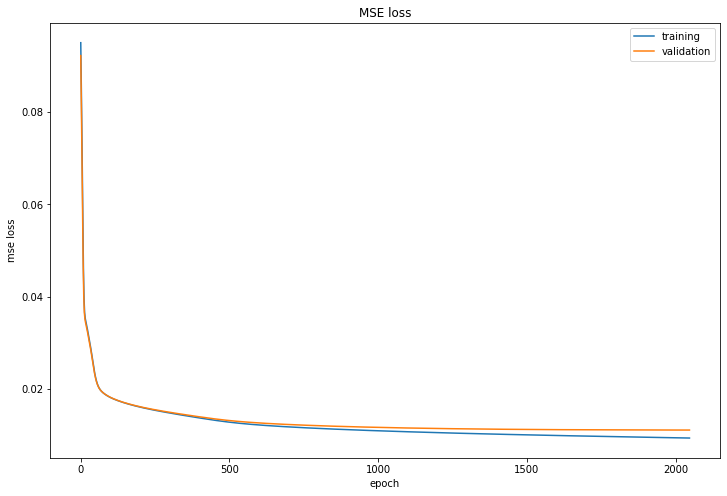

In [17]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
plt.title('MSE loss')

In [18]:
predictions = model.predict(test_input)

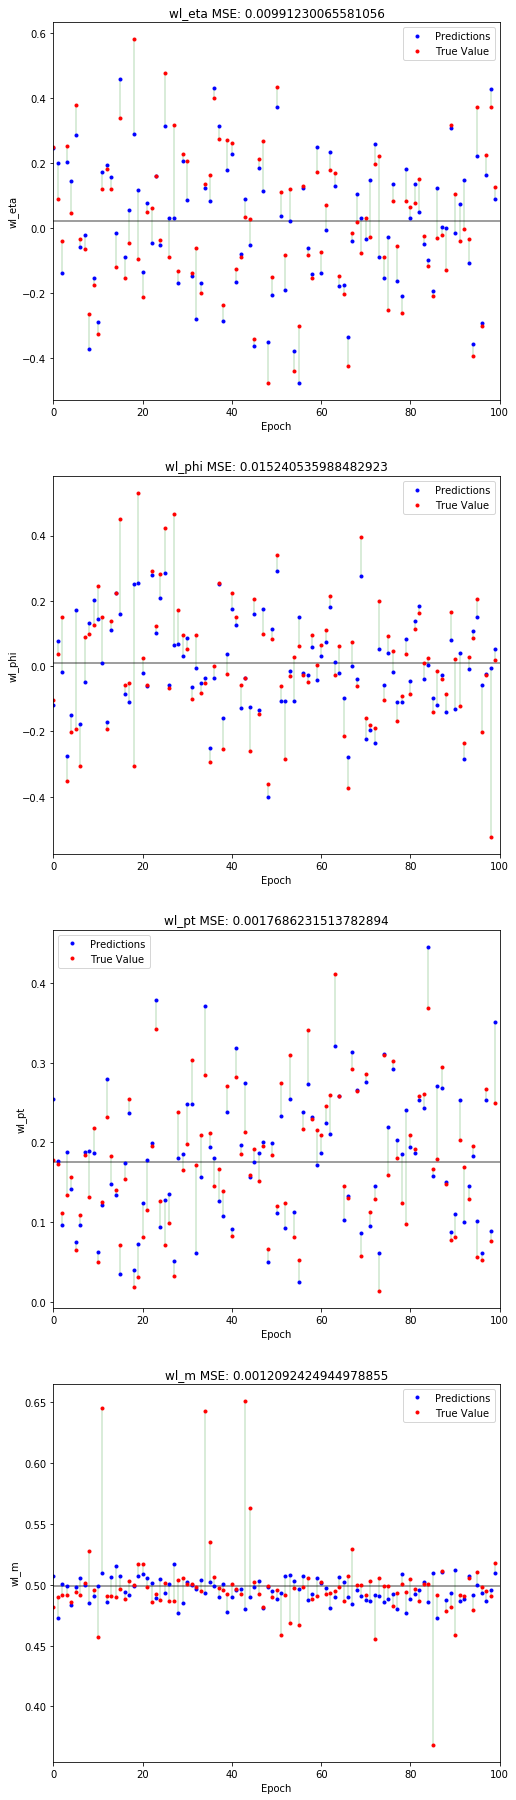

In [19]:

# Training 
crop = 100 

train_small = model.predict(train_input[0:100,:])
output_small = train_output[0:100,:]

def comparison_plot(compare, true):
    plt.figure(figsize=(8,8*output_length))
    for i in range(0,output_length):
        plt.subplot(output_length,1,i+1)
        plt.plot(range(0,crop), compare[:,i], 'bo', markersize=3, label = 'Predictions')
        plt.plot(range(0,crop), true[:,i], 'ro', markersize=3, label = 'True Value')
        ym, yM = plt.ylim()
        for x in range(100):
            plt.vlines(x, color='g', linestyle='-', alpha=0.2, ymin= 
                        min(compare[x,i], true[x,i]), 
                        ymax= max(compare[x,i], true[x,i]))
        plt.hlines(np.mean(true[:,i]), xmin=-20, xmax=crop+20, alpha=0.5)
        MSE = 1/compare[:,i].size*np.sum((compare[:,i]- true[:,i])**2)
        plt.xlabel('Epoch')
        plt.ylabel(output_keys[i])
        plt.xlim(0, crop)
        plt.title(output_keys[i] + " MSE: " + str(MSE))
        plt.legend()

comparison_plot(train_small, output_small)

In [20]:
# Predictions

predictions_small = predictions[0:100,:]
test_output_small = test_output[0:100,:]

MSE = 1/predictions.size*np.sum((predictions- test_output)**2)
print("total MSE: " + str(MSE))

for i in range(output_length):
    MSE = 1/predictions[:,i].size*np.sum((predictions[:,i] -test_output[:,i])**2)
    print("{0} MSE : ".format(output_keys[i]), '%.10f'%MSE)

total MSE: 0.00955465232928423
wl_eta MSE :  0.0090949188
wl_phi MSE :  0.0254657097
wl_pt MSE :  0.0022165098
wl_m MSE :  0.0014414711


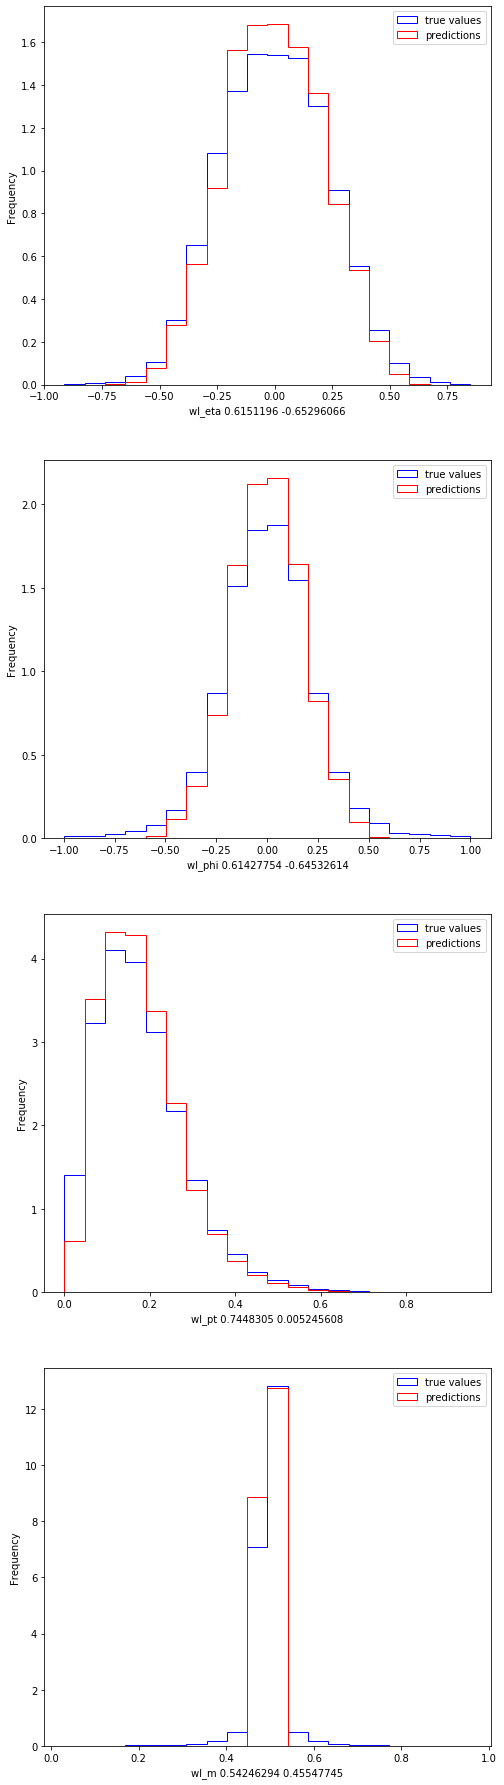

In [21]:
# Unscaled Histograms 

plt.figure(figsize=(8,8*output_length))
for i in range(len(output_keys)):
    plt.subplot(output_length, 1, i+1)
    hist0, bin_edges = np.histogram(test_output[:, i], bins=20)
    plt.hist(test_output[:,i], bin_edges, histtype='step', color='b', label='true values', density=True)
    plt.hist(predictions[:,i], bin_edges, histtype='step', color='r', label='predictions', density=True)
    plt.xlabel(output_keys[i] +" " +str(np.max(predictions[:,i])) + " " + str(np.min(predictions[:,i])))
    plt.legend()
    plt.ylabel('Frequency')

In [22]:
total_output = scale_arrays(output_keys, maxmean)
out_scaled = invscale_arrays(output_keys, total_output, maxmean)[split:,:]

total_predictions = model.predict(total_input)
predict_scaled = invscale_arrays(output_keys, total_predictions, maxmean)[split:,:]


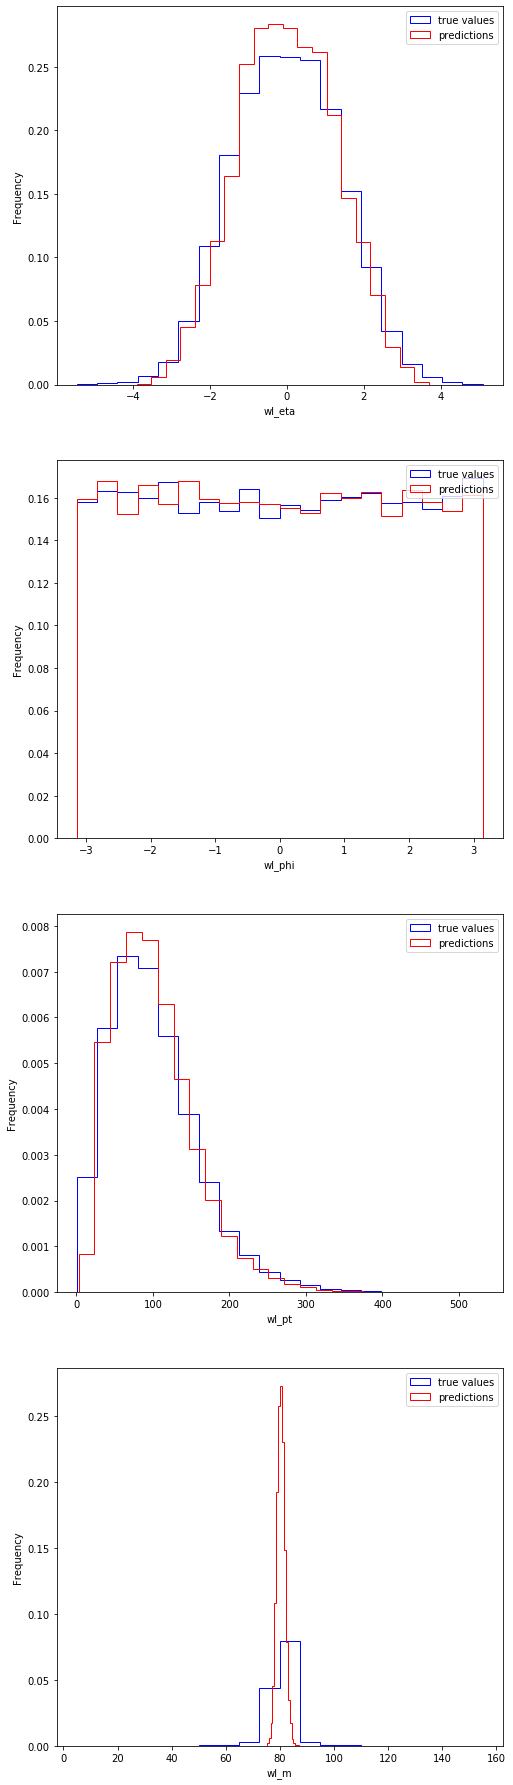

In [23]:
# Histograms to the original scale 

# out_scaled = invscale_arrays(output_keys, out_max0, out_mean, total_output)
# out_scaled = invscale_arrays(output_keys, test_output, maxmean)
# predict_scaled = invscale_arrays(output_keys, out_max0, out_mean, total_predictions)[split:,:]


plt.figure(figsize=(8,8*output_length))
for i in range(len(output_keys)):
    plt.subplot(output_length, 1, i+1)
    # hist0, bin_edges = np.histogram(out_scaled[:, i], bins=20)
    plt.hist(out_scaled[:, i], 20, histtype='step', color='b', label='true values', density=True)
    plt.hist(predict_scaled[:, i], 20, histtype='step', color='r', label='predictions', density=True)
    plt.xlabel(output_keys[i])
    plt.legend()
    plt.ylabel('Frequency')

In [24]:
for i in range(output_length):
    if output_keys[i].split("_")[1] == 'phi':
        mod_pi = (predict_scaled[:,i] - out_scaled[:,i]) % (2*np.pi)
        mod_pi = mod_pi - 2*np.pi*(mod_pi > np.pi)
        MSE = 1/predict_scaled[:,i].size*np.sum((mod_pi)**2)
    else:
        MSE = 1/predict_scaled[:,i].size*np.sum((predict_scaled[:,i] - out_scaled[:,i])**2)
    print("Original Scale {0} MSE : ".format(output_keys[i]), '%.10f'%MSE)

Original Scale wl_eta MSE :  0.3257063674
Original Scale wl_phi MSE :  0.2301254821
Original Scale wl_pt MSE :  693.0103464510
Original Scale wl_m MSE :  37.7657355391


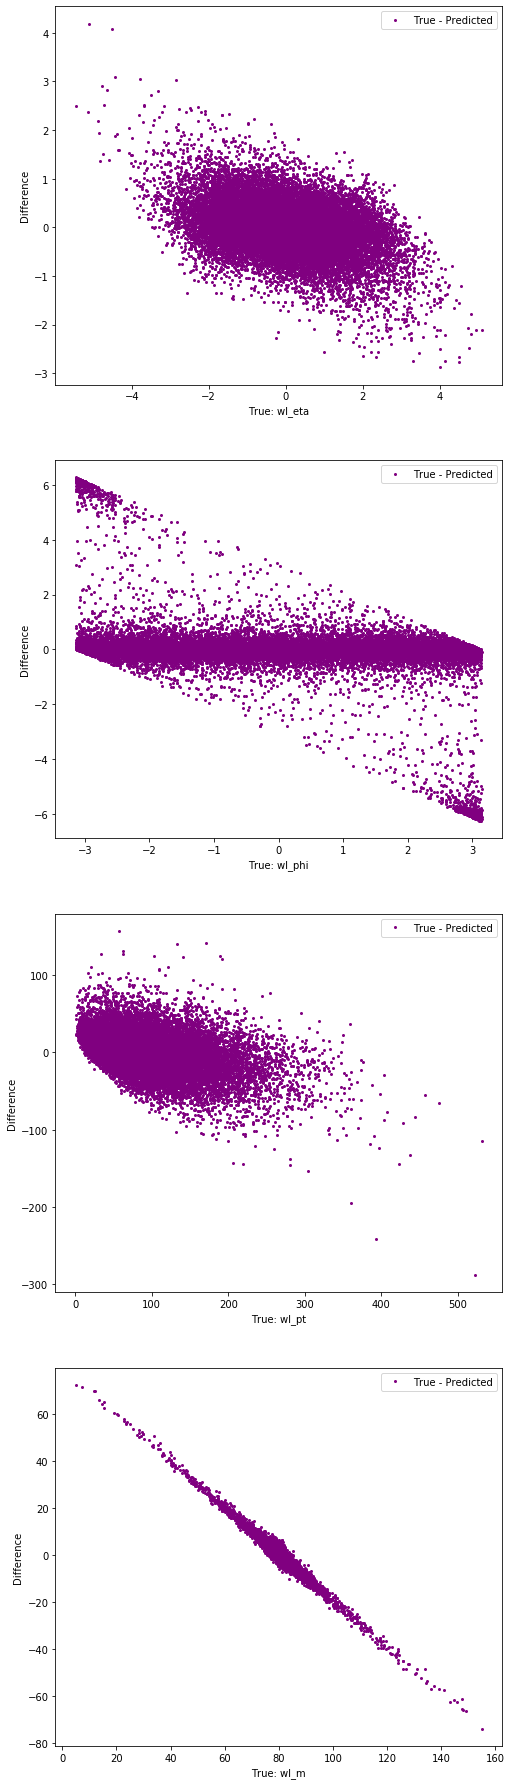

In [25]:
plt.figure(figsize=(8,8*output_length))
for i in range(output_length):
    plt.subplot(output_length, 1, i+1)
    # hist0, bin_edges = np.histogram(out_scaled[:, i], bins=20)
    plt.plot(out_scaled[:, i], predict_scaled[:, i]-out_scaled[:, i], 'o', color='purple', label='True - Predicted', markersize=2)
    plt.xlabel('True: ' + output_keys[i])
    plt.legend()
    plt.ylabel('Difference')